# Using Netket's New Symmetry Interface to Model Broken Symmetries

Today we'll be taking a dive into Netket's new symmetry interface. This package allows you to find the lowest energy eigenstate under a given discrete symmetry representation. This is an extremely useful tool for probing the zero-temperature phase diagram of quantum systems, as it allows you to find the ground states and low-lying excited states. 

For ordered states on symmetric lattices, the low-lying energy levels typically follow a tower of states representation, where the low-lying energy levels are determined by the symmetry breaking. Quantum spin liquids don't break global symmetries, but they still have a unique excitation signatures. Therefore, we can distinguish quantum phases by looking at the structure of the excitation spectrum, and estimate phase transitions by level crossings. 

We'll begin today by learning how to create lattices, assign them with symmetries, and generate character tables corresponding to irreducible representations. Then we will do a tower of states analysis $J_1-J_2$ Heisenberg model on the Square lattice, which is thought to give rise to a spin liquid state in the range $\frac{J_2}{J_1} \in [0.49,0.54]$.

First let's learn about the symmetry interface! Let's begin by installing Netket in this notebook and importing the essentials. Before running any of the code press the dropdown arrow to the right of the horizontal gray bars and press "view resources". Press the blue link that says "change runtime type" and select GPU from the dropdown menu.

In [1]:
!pip install --upgrade "git+https://github.com/netket/netket"

import netket as nk
import numpy as np
from matplotlib import pylab as plt
import json
from jax.scipy.sparse.linalg import cg



  Cloning https://github.com/netket/netket to /tmp/pip-req-build-iq6q3ihf
  Running command git clone -q https://github.com/netket/netket /tmp/pip-req-build-iq6q3ihf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 126 kB 70.4 MB/s 
     |████████████████████████████████| 247 kB 61.8 MB/s 
     |████████████████████████████████| 3.2 MB 60.4 MB/s 
     |████████████████████████████████| 207 kB 69.1 MB/s 
     |████████████████████████████████| 3.3 MB 42.0 MB/s 
     |████████████████████████████████| 471 kB 62.7 MB/s 
     |████████████████████████████████| 26.3 MB 1.4 MB/s 
     |████████████████████████████████| 65 kB 4.8 MB/s 
  Created wheel for netket: filename=netket-3.3-py3-none-any.whl size=479805 sha256=20cf47c2020554e9144987125bd6f2c976558422420e362ea08aa68acd195623
  Stored in directory: /tmp/pip-ephem-w

First, we'll describe how you can build a lattice with a symmetry group. If it's a common lattice, you can load it directly from NetKet's prebuilt lattices. Let's create a 4x4 square lattice.

In [2]:
from netket.graph import Square
L = 4
square_lattice = Square(4)

A `Lattice` object stores graph information in two different ways, as a collection of nodes and edges, and as a set of coordinates. We can assign it with a `point_group`, which includes the symmetry elements (excluding translations) that map the lattice to itself. NetKet will automatically calculate the space group, which includes translations, from the point group. While the `point_group` and `space_group` objects can be computed from a coordinate representation, they operate as a set of permutations on a graph. Let's take a look at our `group` objects.

In [3]:
#Compute point group as permutations on lattice
point_group = square_lattice.point_group()

#Compute space group as permutations on lattice
space_group = square_lattice.space_group()

#Access the array of space group permutations
space_group_as_array = np.asarray(space_group)

print(point_group)
print(space_group)
print(space_group_as_array)

PermutationGroup(elems=[Id(), Refl(0°), Refl(90°), Rot(180°), Refl(45°), Rot(90°), Rot(-90°), Refl(-45°)], degree=16)
PermutationGroup(elems=[Id(), Refl(0°), Refl(90°), Rot(180°), Refl(45°), Rot(90°), Rot(-90°), Refl(-45°), Translation([0, 1]), Translation([0, 1]) @ Refl(0°), Translation([0, 1]) @ Refl(90°), Translation([0, 1]) @ Rot(180°), Translation([0, 1]) @ Refl(45°), Translation([0, 1]) @ Rot(90°), Translation([0, 1]) @ Rot(-90°), Translation([0, 1]) @ Refl(-45°), Translation([0, 2]), Translation([0, 2]) @ Refl(0°), Translation([0, 2]) @ Refl(90°), Translation([0, 2]) @ Rot(180°), Translation([0, 2]) @ Refl(45°), Translation([0, 2]) @ Rot(90°), Translation([0, 2]) @ Rot(-90°), Translation([0, 2]) @ Refl(-45°), Translation([0, 3]), Translation([0, 3]) @ Refl(0°), Translation([0, 3]) @ Refl(90°), Translation([0, 3]) @ Rot(180°), Translation([0, 3]) @ Refl(45°), Translation([0, 3]) @ Rot(90°), Translation([0, 3]) @ Rot(-90°), Translation([0, 3]) @ Refl(-45°), Translation([1, 0]), Tr

We can also create a lattice with a space group from scratch. In this case we must specify the locations of the unit cells and the coordinates within the unit cell. Let's create an identical square lattice using `nk.graph.Lattice`. The edges  will be exactly the same and the point/space groups will have all of the same elements (The order is slightly different as `Square` is created from a `Hypercube` class) 

In [4]:
from netket.utils.group.planar import D

square_lattice2 = nk.graph.Lattice(basis_vectors=[[1,0],[0,1]],site_offsets=[[0,0]],extent=[L,L],point_group=D(4))

print(point_group)
print(square_lattice2.point_group())

assert np.all(square_lattice2.edges() == square_lattice.edges())

PermutationGroup(elems=[Id(), Refl(0°), Refl(90°), Rot(180°), Refl(45°), Rot(90°), Rot(-90°), Refl(-45°)], degree=16)
PermutationGroup(elems=[Id(), Rot(90°), Rot(180°), Rot(-90°), Refl(0°), Refl(-45°), Refl(-90°), Refl(45°)], degree=16)


Finally, we could also create the same lattice as a `Graph`, which is just a list of edges with no coordinates. With a graph object, we can still compute the symmetry group by calling `graph.automorphisms()` although the symmetry elements will be unlabeled. We see that all of these graphs will have the same symmetry elements

In [5]:
edges = []

for i in range(L*L):
  x = i % L
  y = i // L

  xn = (x + 1) % L

  edges.append((x + y*L,xn+y*L))

  yn = (y + 1) % L 

  edges.append((x + y*L,x+yn*L))

square_lattice3 = nk.graph.Graph(edges=edges)

assert len(square_lattice.automorphisms()) == len(square_lattice3.automorphisms())

Now we've created a square lattice three different ways, let's learn how to find it's representations. As physicists, we often want to select a representation from the little group, which is the point group at a fixed momentum. We can do this by calling `graph.space_group_builder()`. Let's look at the characters of the little groups at high-symmetry points in the Brillouin zone. 

In [6]:
from math import pi

sgb = square_lattice.space_group_builder()

#character table at the Γ point
print(sgb.little_group([0,0]).character_table_readable())

#character table at the X point
print(sgb.little_group([pi,0]).character_table_readable())

#character table at the M point
print(sgb.little_group([pi,pi]).character_table_readable())


(['1xId()', '2xRefl(0°)', '1xRot(180°)', '2xRefl(45°)', '2xRot(90°)'], array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1., -1., -1.],
       [ 1., -1.,  1.,  1., -1.],
       [ 1., -1.,  1., -1.,  1.],
       [ 2.,  0., -2.,  0.,  0.]]))
(['1xId()', '1xRefl(0°)', '1xRefl(90°)', '1xRot(180°)'], array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1., -1., -1.],
       [ 1., -1.,  1., -1.],
       [ 1., -1., -1.,  1.]]))
(['1xId()', '2xRefl(0°)', '1xRot(180°)', '2xRefl(45°)', '2xRot(90°)'], array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1., -1., -1.],
       [ 1., -1.,  1.,  1., -1.],
       [ 1., -1.,  1., -1.,  1.],
       [ 2.,  0., -2.,  0.,  0.]]))


We can see that both the Γ and M points transform under the full point group $D_4$, while the X point only transforms under $D_2$. While `little_group(k).character_table_readable()` will give a compact description of the little group, `space_group_irreps()` will calculate the full character



In [7]:
#ΓA1 character
print(sgb.space_group_irreps([0,0])[0])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


Now that we've learned the basics, let's do some science! For time efficiency we're going to look at the Neel order and VBS goldstone modes and see how they change as we evolve J2. We will train models at $J_2 = 0.4$ and continutally evolve the models until we reach $J_2 = 0.6$, slowly enough that we stay in an energy minimum. We can do this adiabatic evolution so long as there is not a level crossing within a given representation. 

Let's figure out the Goldstone modes. The Neel ordered state is pictured below.

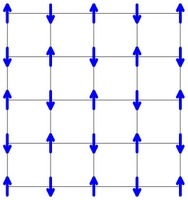

We can determine the tower of states by examining how the ordering maps to itself. The Neel ordering maps to itself under a translation and a spin inversion. This means we need a representation such that eigenvalues of translation and spin parity multiply to one. This is satisfied by the ΓA1+ and MA1- representations where the +/- indicates spin parity. These two levels should have exponentially small splitting.

On the other side of the QSL we have a columnar valence bond solid which is pictured below. The circled bonds indicate singlets

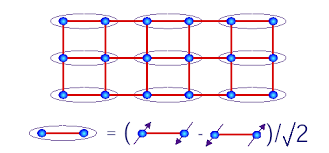

Obviously, the bonds could equivalently be vertical or horizontal. As you can see, the VBS breaks both translational symmetry and rotational symmetry. The lattice maps to itself via a translation in the y direction, a two fold translation in the x direction, an x translation plus a 180 degree rotation about one of the lattice sites, and a reflection about the x-axis. This indicates that in addition to the fully symmetric irrep, we have a X irrep with eigenvalue -1 with respect to the 180 degree rotations and eigenvalue 1 with respect to x-axis reflection. Let's check the character of the little group.

In [8]:
print(sgb.little_group([pi,0]).character_table_readable())

(['1xId()', '1xRefl(0°)', '1xRefl(90°)', '1xRot(180°)'], array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1., -1., -1.],
       [ 1., -1.,  1., -1.],
       [ 1., -1., -1.,  1.]]))


In this case the angle of the reflection plane is given with respect to the x axis. Therefore, we want the second representation in that table, i.e. the XB1+

Let's define our Hilbert space and Hamiltonian. We will build a next neighbor graph to include the $J_2$ interaction

In [9]:
nn_edges = []

for n in range(L*L):

  x = n // L
  y = n % L

  for pair in [(1,1),(-1,1)]:
    nx = (x + pair[0]) % L
    ny = (y + pair[1]) % L

    nn_edges.append((n,nx*L + ny))

nn_graph = nk.graph.Graph(edges=nn_edges)

def build_Hamiltonian(J2,nn_graph,hi):

  ha = nk.operator.Heisenberg(hilbert=hi, graph=square_lattice,sign_rule=False) + nk.operator.Heisenberg(hilbert=hi, graph=nn_graph,J=J2,sign_rule=False)

  return ha


Now lets define our model. We will build a group convolutinal neural network with 4 layers and 6 features. We can need to give it a `Lattice` object and a character table and the rest will be taken care of! We can also specify the eigenvalue with respect to spin inversion by setting parity = $\pm 1$. The function below will build a model that transforms under the desired representation.

In [10]:

#function to choose representation (these are in TOS for VBS and Neel order)

def build_GCNN(irrep):
  if irrep == "Γ𝐴1+":
    chars = sgb.space_group_irreps([0,0])[0]
    ma = nk.models.GCNN(symmetries=square_lattice,features=6,layers=4,parity=1,dtype=complex,characters=chars,mode='irreps')
  if irrep == "XB1+":
    chars = sgb.space_group_irreps([pi,0])[1]
    ma = nk.models.GCNN(symmetries=square_lattice,features=6,layers=4,parity=1,dtype=complex,characters=chars,mode='irreps')
  if irrep == "M𝐴1-":
    chars = sgb.space_group_irreps([pi,pi])[0]
    ma = nk.models.GCNN(symmetries=square_lattice,features=6,layers=4,parity=-1,dtype=complex,characters=chars,mode='irreps')

  return ma 




Now we can define the optimization procedure. We will sample using metropolis Hastings and optimize using stochaistic gradient descent. Once we are close to a solution, we will slow the learning rate down so we get an accurate optimization. Next, we will adiabatically change J2 from 0.4 to 0.6 to trace the evolution of the energy. 

In [11]:

def run_optimization(irrep):
  
  #create Hilbert space
  hi = nk.hilbert.Spin(s=0.5, total_sz = 0, N=square_lattice.n_nodes)

  #create Hamiltonian
  ha = build_Hamiltonian(0.4,nn_graph,hi)

  #Sampler
  sa = nk.sampler.MetropolisExchange(hilbert=hi,n_chains=1000,graph=square_lattice,d_max=2)

  #Gradient descent optimizer
  op = nk.optimizer.Sgd(learning_rate=5e-2)

  #stochaistic reconfiguration
  sr = nk.optimizer.SR(nk.optimizer.qgt.QGTJacobianPyTree, solver=cg, diag_shift=1e-2,holomorphic=False)

  ma = build_GCNN(irrep)

  vstate = nk.vqs.MCState(sampler=sa, model=ma, n_samples=1000,n_discard_per_chain=0)

  gs = nk.driver.VMC(ha, op, variational_state=vstate,preconditioner=sr)
  gs.run(n_iter=150,out=None)

  op = nk.optimizer.Sgd(learning_rate=1e-2)
  gs = nk.driver.VMC(ha, op, variational_state=vstate,preconditioner=sr)
  gs.run(n_iter=50,out=None)

  ens = []

  for i in range(200):
    J2 = 0.4 + i*0.001
    ha = build_Hamiltonian(J2,nn_graph,hi)
    gs = nk.driver.VMC(ha, op, variational_state=vstate,preconditioner=sr)
    gs.run(n_iter=1,out='tmp')
    energy = np.mean(json.load(open('tmp.log'))["Energy"]["Mean"]["real"])
    ens.append(energy)

  return ens

Now lets run the optimizations. Each of these will take around 40 mins on a GPU. We expect to see a level crossing between the MA1- irrep for Neel order and the XB1+ irrep for stripy order. 

In [ ]:
ens_gs = run_optimization("Γ𝐴1+")
ens_neel = run_optimization("M𝐴1-")
ens_VBS = run_optimization("XB1+")

We see that the variance increases as we change J2. This is because we are moving fairly quickly and not giving the model enough time to adjust. We could remedy this by decreasing the change in J2 at each iteration. Let's plot our results!

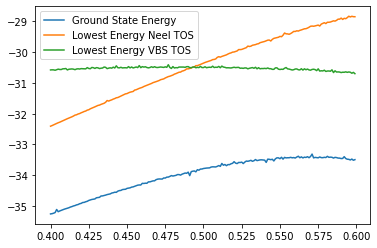

In [ ]:
plt.plot(np.arange(0.4,0.6,0.001),ens_gs)
plt.plot(np.arange(0.4,0.6,0.001),ens_neel)
plt.plot(np.arange(0.4,0.6,0.001),ens_VBS)
plt.plot(np.arange(0.4,0.6,0.001),ens_quintuplet)

plt.legend(labels=["Ground State Energy", "Lowest Energy Neel TOS","Lowest Energy VBS TOS","Quintuplet"])

Voila, we see the level crossing we were promised! As it turns out, this level crossing indicates the transition from QSL to VBS as the Neel order Goldstone mode is becoming gapped. 

To see the Neel QSL transition we'd have to look for where the VBS mode crosses under the quintuplet. By the squeezing theorem, this indicates the VBS mode becoming gapless. We could simulate the quintuplet by looking for the Γ𝐴1 irrep and constraining the sampler to `total_sz = 2`. 

Since we only looked at a 16 site lattice, we could have done today's calculation quite easily with exact diagonalization. However, using NNQS we can scale to much bigger system sizes. By extrapolating to the thermondynamic limit, we can uncover information about the quantum phases from the excitation spectrum.     

